# AI - Neural Networks

Name: `Mahsa Amani`

Student ID: `97105769`

## Install the requirements

In [ ]:
!pip install -r requirements.txt

In [ ]:
import numpy as np
import hw4_helper
import torch

## Load train dataset
Note that the dataset will be downloaded in the `data_cache` directory for the first time. So do not remove that directory.

In [ ]:
x_train, y_train = hw4_helper.get_train_data()
x_train.shape, y_train.shape

((98000, 28, 28), (98000,))

## Design your model

Write your neural network model below. Feel free to add extra cells.

In [ ]:
from sklearn.model_selection import train_test_split

data = list(zip(x_train, y_train))
train_data, validation_data = train_test_split(data, test_size=0.1)

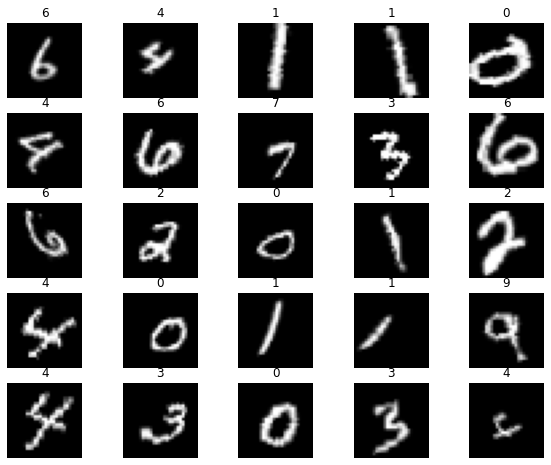

In [ ]:
import matplotlib.pyplot as plt

# data visalization
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [ ]:
cnn = CNN()
print(cnn)

CNN(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=3136, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [ ]:
loss_function = torch.nn.CrossEntropyLoss()   

In [ ]:
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.001)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

## Train your Model
Write the training proecss below. Fell free to add extra cells

In [ ]:
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch

num_epochs = 10
train_batch_loss = [list()] * num_epochs
val_batch_loss   = [list()] * num_epochs
train_epoch_loss = []
val_epoch_loss   = []
train_accuracies = []
val_accuracies = []
train_accuracy = 0
val_accuracy = 0
misclassified = []

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=100, shuffle=True)

for epoch in range(num_epochs):
    cnn.train()
    correct_predictions = 0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()    

        images = np.expand_dims(images, 1)   
        b_x = torch.from_numpy(np.array(images))
        b_y = torch.from_numpy(np.array(labels)) 
        output = cnn(b_x)

        loss = loss_function(output, b_y)
        train_batch_loss[epoch].append(loss.item())
         
        loss.backward()    
        optimizer.step() 

        output = torch.nn.functional.softmax(output, dim=1)
        for j, p in enumerate(output):
            if labels[j] == torch.max(p.data, 0)[1]:
                correct_predictions += 1               
    
    train_accuracy = 100 * correct_predictions / len(train_data)
    train_accuracies.append(train_accuracy)

    cnn.eval()
    correct_predictions = 0
    for i, (images, labels) in enumerate(val_loader):
        images = np.expand_dims(images, 1)   
        v_x = torch.from_numpy(np.array(images))
        v_y = torch.from_numpy(np.array(labels)) 
        output = cnn(v_x)

        loss = loss_function(output, v_y)
        val_batch_loss[epoch].append(loss.item())

        output = torch.nn.functional.softmax(output, dim=1)
        for j, p in enumerate(output):
            pred = torch.max(p.data, 0)[1]
            if labels[j] == pred:
                correct_predictions += 1
            else:
                misclassified.append((images[j], labels[j], pred))

    val_accuracy = 100 * correct_predictions / len(validation_data)
    val_accuracies.append(val_accuracy)
    train_epoch_loss.append(np.mean(train_batch_loss[epoch]))
    val_epoch_loss.append(np.mean(val_batch_loss[epoch]))
    print('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}'
        .format(epoch + 1, num_epochs, train_epoch_loss[-1], val_epoch_loss[-1], train_accuracies[-1], val_accuracies[-1]))


Epoch [1/10], Train Loss: 0.8578, Validation Loss: 0.3852, Train Accuracy: 71.9104, Validation Accuracy: 88.1122
Epoch [2/10], Train Loss: 0.6565, Validation Loss: 0.3320, Train Accuracy: 85.8685, Validation Accuracy: 91.2959
Epoch [3/10], Train Loss: 0.5559, Validation Loss: 0.2992, Train Accuracy: 89.0181, Validation Accuracy: 92.6020
Epoch [4/10], Train Loss: 0.4919, Validation Loss: 0.2742, Train Accuracy: 90.7630, Validation Accuracy: 93.8673
Epoch [5/10], Train Loss: 0.4463, Validation Loss: 0.2562, Train Accuracy: 91.8832, Validation Accuracy: 94.3776
Epoch [6/10], Train Loss: 0.4111, Validation Loss: 0.2442, Train Accuracy: 92.6995, Validation Accuracy: 94.5306
Epoch [7/10], Train Loss: 0.3832, Validation Loss: 0.2344, Train Accuracy: 93.2619, Validation Accuracy: 94.6429
Epoch [8/10], Train Loss: 0.3605, Validation Loss: 0.2257, Train Accuracy: 93.6338, Validation Accuracy: 94.9490
Epoch [9/10], Train Loss: 0.3410, Validation Loss: 0.2183, Train Accuracy: 94.0726, Validation A

## Draw the training curves
Draw two diagrams for train and validation, one showing loss of each epoch, and another showing accuracy of each epoch.

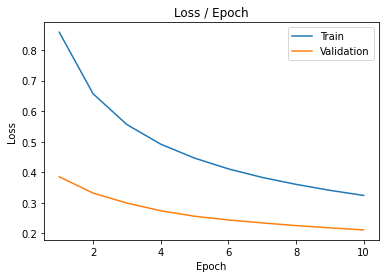

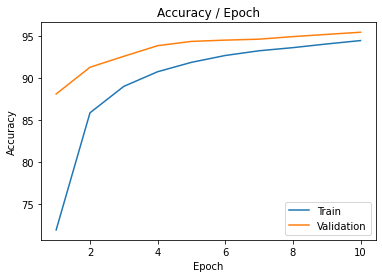

In [ ]:
X = np.arange(1, num_epochs+1)

plt.plot(X, train_epoch_loss, label="Train")
plt.plot(X, val_epoch_loss, label="Validation")
plt.title("Loss / Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
  
plt.plot(X, train_accuracies, label="Train")
plt.plot(X, val_accuracies, label="Validation")
plt.title("Accuracy / Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Draw misclassified images
Draw 10 misclassified images from validation set with expected and predicted labels

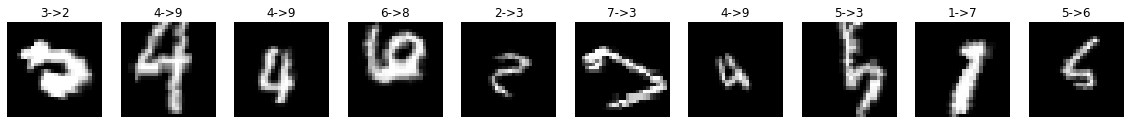

In [ ]:
num_misclassified = 10

figure = plt.figure(figsize=(20, 10))
for i in range(1, num_misclassified + 1):
    sample_idx = torch.randint(len(misclassified), size=(1,)).item()
    img, expected_label, predicted_label = misclassified[sample_idx][0], misclassified[sample_idx][1], misclassified[sample_idx][2]
    figure.add_subplot(1, num_misclassified, i)
    s = str(expected_label.item()) +  "->" + str(predicted_label.item())
    plt.title(s)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Evaluate your model on the test dataset

### Load test dataset
Note that the dataset will be downloaded for hte first time in the `data_cache` directory. So do not remove that directory.

In [ ]:
x_test = hw4_helper.get_test_data()
x_test.shape

100%|██████████| 62.8M/62.8M [00:00<00:00, 89.3MB/s]


(21000, 28, 28)

### Run your model on test data

In [ ]:
cnn.eval()
correct_predictions = 0
prediction = np.zeros(len(x_test))
test_loader = DataLoader(x_test, batch_size=1, shuffle=False)

for i, image in enumerate(test_loader):
    image = np.expand_dims(image, 1)   
    x = torch.from_numpy(np.array(image))
    output = cnn(x)
    output = torch.nn.functional.softmax(output, dim=1)
    for j, p in enumerate(output):
        pred = torch.max(p.data, 0)[1]
        prediction[i] = pred

### Save the predictions
The following helper function will save the given prediction array (as a 1D numpy array) to `prediction.npy`. Upload this file with this notebook to quera as a `zip` file.

In [ ]:
hw4_helper.export_prediction(prediction)

### Evaluate your predictions
The following helper function calls the test API with the given prediction array (as a 1D numpy array) and prints the server result.

In [ ]:
hw4_helper.test(prediction)

Status: 200 - message: Your accuracy is 95.70%.


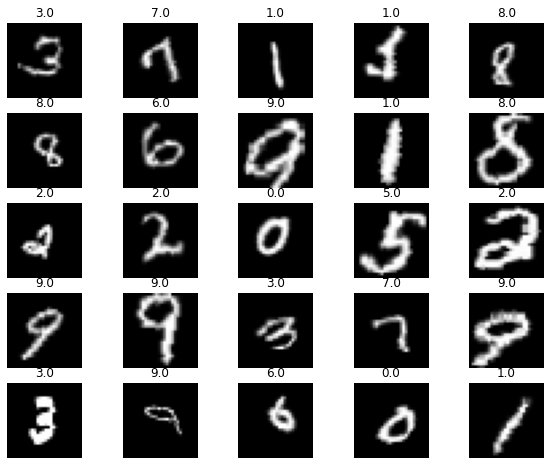

In [ ]:
# data visalization
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = i
    img = x_test[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(prediction[i])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()